AI-Assistant That Help to Dicover Jordan

In [3]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import sqlite3

c:\Users\mah19\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print("OpenAI API Key exists")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4.1-mini"
openai = OpenAI()

OpenAI API Key exists


In [5]:
system_message = """
You are a helpful assistant for an Airline called discover jordan, specialized in destinations within Jordan.
Give short, courteous answers in no more than 1 sentence.
In addition to flight cost estimates, provide a brief historical fact or mention a famous landmark of the Jordanian governorate when relevant.
Always be accurate; if you don't know the answer, say so.
"""


In [6]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the ticket price and a brief tourist or historical fact about a destination in Jordan.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "Jordanian city or tourist destination name"
            }
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}


In [7]:
tools = [{"type": "function", "function": price_function}]

In [20]:
def chat(history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    cities = []
    image = None

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses, cities = handle_tool_calls_and_return_cities(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    voice = talker(reply)

    if cities:
        image = artist(cities[0])
    
    return history, voice, image

In [9]:
conn = sqlite3.connect("flightai.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS destinations (
    city TEXT PRIMARY KEY,
    price TEXT,
    landmark TEXT
)
""")

destinations = [
    ("amman", "$120", "the capital of Jordan, known for the Citadel and Roman Theater"),
    ("irbid", "$110", "famous for its cultural history and proximity to Umm Qais"),
    ("jerash", "$130", "home to the ancient Roman city of Jerash"),
    ("aqaba", "$150", "Jordan’s coastal city on the Red Sea, famous for diving"),
    ("petra", "$180", "home to Petra, one of the New Seven Wonders"),
    ("wadi rum", "$170", "the Valley of the Moon, known for red desert landscapes"),
    ("dead sea", "$160", "the lowest point on Earth, famous for floating waters"),
    ("madaba", "$125", "known for its Byzantine mosaics and the Madaba Map"),
    ("karak", "$135", "famous for the historic Karak Castle"),
    ("salt", "$115", "one of Jordan’s oldest cities with Ottoman-era architecture")
]

cursor.executemany(
    "INSERT OR REPLACE INTO destinations VALUES (?, ?, ?)",
    destinations
)

conn.commit()
conn.close()


In [10]:
def get_ticket_price(destination_city):
    conn = sqlite3.connect("flightai.db")
    cursor = conn.cursor()

    cursor.execute(
        "SELECT price, landmark FROM destinations WHERE city = ?",
        (destination_city.lower(),)
    )

    result = cursor.fetchone()
    conn.close()

    if not result:
        return f"Sorry, I don’t have information about {destination_city}."

    price, landmark = result
    return f"A ticket to {destination_city.title()} costs {price}, and it is known for {landmark}."

In [11]:
get_ticket_price("dead sea")

'A ticket to Dead Sea costs $160, and it is known for the lowest point on Earth, famous for floating waters.'

In [21]:
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []

    if not hasattr(message, "tool_calls") or message.tool_calls is None:
        return responses, cities

    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get("destination_city")
            cities.append(city)
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "tool_call_id": tool_call.id,
                "content": [{"type": "text", "text": price_details}]
            })

    return responses, cities


In [15]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [16]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

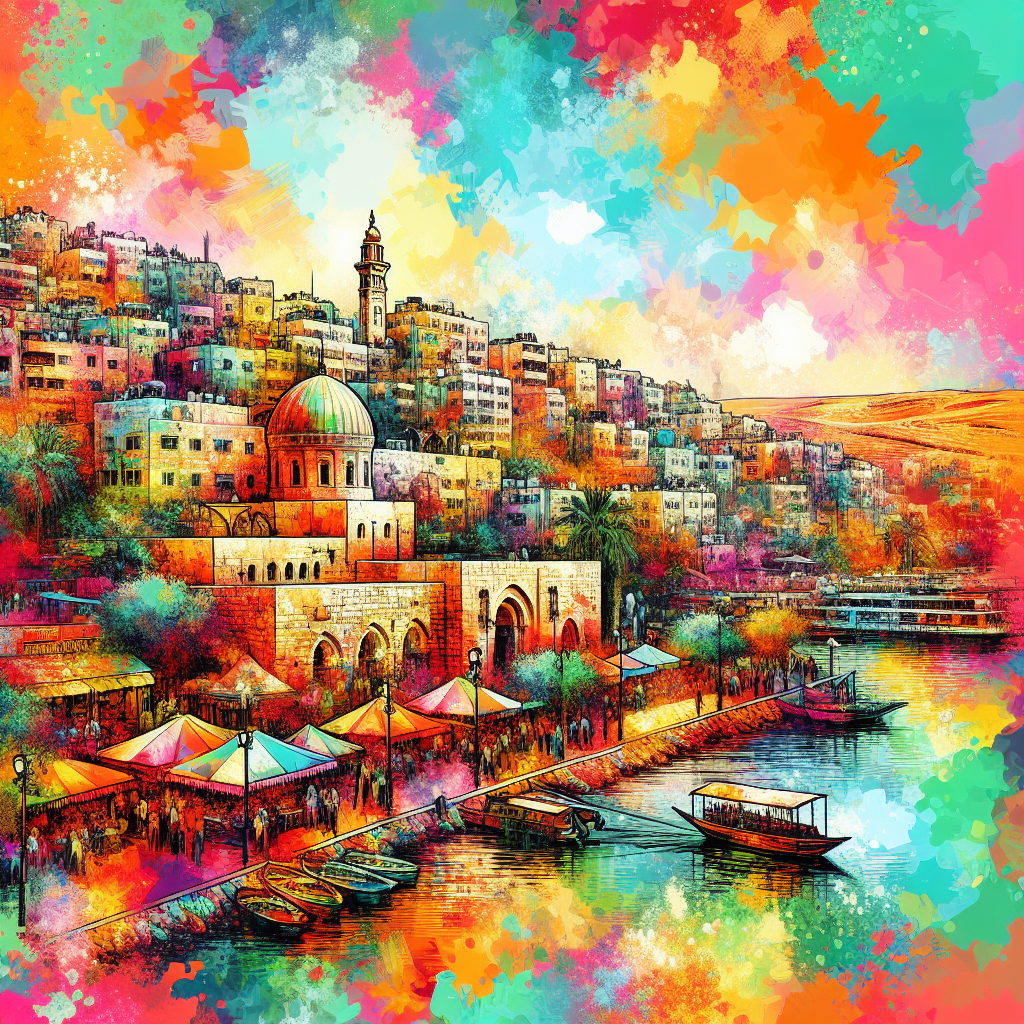

In [17]:
artist("amman")

In [14]:
def talker(message):
    response = openai.audio.speech.create(
      model="gpt-4o-mini-tts",
      voice="onyx",    # Also, try replacing onyx with alloy or coral
      input=message
    )
    return response.content

In [22]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500)
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Discover Jordan with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )

ui.launch(inbrowser=True, auth=("Mohd", "12345678"))

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Exception in callback _ProactorBasePipeTransport._call_connection_lost()
handle: <Handle _ProactorBasePipeTransport._call_connection_lost()>
Traceback (most recent call last):
  File "c:\Users\mah19\AppData\Local\Programs\Python\Python313\Lib\asyncio\events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mah19\AppData\Local\Programs\Python\Python313\Lib\asyncio\proactor_events.py", line 165, in _call_connection_lost
    self._sock.shutdown(socket.SHUT_RDWR)
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host


In [ ]:
from PIL import Image

img = Image.open("discover jordan output.jpg")
img.show()
